### Biomass Weight Estimation Model

In [1]:
# import Libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

# scaling library
from sklearn.model_selection import train_test_split  # imports the train_test_split function
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# visualization library
import matplotlib.pyplot as plt
import seaborn as sns

# Check if the model is performing optimally
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

# from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

# Ignoring Warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.set_style("whitegrid", {'axes.grid' : False})

#### READ DATA

In [3]:
biomass_data = pd.read_csv('data/Weight Model Final.csv')
biomass_data

,Wood ID,length( cm),circumference (cm),width(mm),wet weight (g),dry weight(g),dry_weight_may24
0,R1,94.0,12.5,35.50,898,466.8,465.0
1,R2,86.0,16.5,49.97,1190,609.2,607.2
2,R3,57.0,12.0,34.06,446,217.2,216.8
3,R4,61.0,16.0,51.13,1018,572.6,568.4
4,R5,76.0,9.5,25.36,396,231.2,231.2
...,...,...,...,...,...,...,...
108,R110,26.5,11.5,36.44,186,125.0,124.6
109,R111,37.8,9.0,26.35,166,128.4,128.2
110,R112,37.5,14.9,38.88,290,181.2,179.8
111,R113,102.0,20.4,63.91,2682,1368.0,1355.4


In [4]:
biomass_data['width (cm)'] = biomass_data['width(mm)']/10  # converting the mm to cm
biomass_data

,Wood ID,length( cm),circumference (cm),width(mm),wet weight (g),dry weight(g),dry_weight_may24,width (cm)
0,R1,94.0,12.5,35.50,898,466.8,465.0,3.550
1,R2,86.0,16.5,49.97,1190,609.2,607.2,4.997
2,R3,57.0,12.0,34.06,446,217.2,216.8,3.406
3,R4,61.0,16.0,51.13,1018,572.6,568.4,5.113
4,R5,76.0,9.5,25.36,396,231.2,231.2,2.536
...,...,...,...,...,...,...,...,...
108,R110,26.5,11.5,36.44,186,125.0,124.6,3.644
109,R111,37.8,9.0,26.35,166,128.4,128.2,2.635
110,R112,37.5,14.9,38.88,290,181.2,179.8,3.888
111,R113,102.0,20.4,63.91,2682,1368.0,1355.4,6.391


Extracting the most relevant features and renaming using simpler convention.

In [5]:
biomass_data.columns

Index(['Wood ID', 'length( cm)', 'circumference (cm)', 'width(mm)',
       'wet weight (g) ', 'dry weight(g)', 'dry_weight_may24', 'width (cm)'],
      dtype='object')

In [6]:
biomass_data_1 = biomass_data[['length( cm)', 'circumference (cm)', 
                     'width (cm)', 'dry_weight_may24']]
biomass_data_1.rename(columns={'length( cm)': 'length', 'width (cm)': 'width',
                    'circumference (cm)': 'circf', 
                     'dry_weight_may24': 'weight'}, inplace=True)
biomass_data_1

,length,circf,width,weight
0,94.0,12.5,3.550,465.0
1,86.0,16.5,4.997,607.2
2,57.0,12.0,3.406,216.8
3,61.0,16.0,5.113,568.4
4,76.0,9.5,2.536,231.2
...,...,...,...,...
108,26.5,11.5,3.644,124.6
109,37.8,9.0,2.635,128.2
110,37.5,14.9,3.888,179.8
111,102.0,20.4,6.391,1355.4


### Exploratory Data Analysis

Text(37.597222222222214, 0.5, 'Weight (g)')

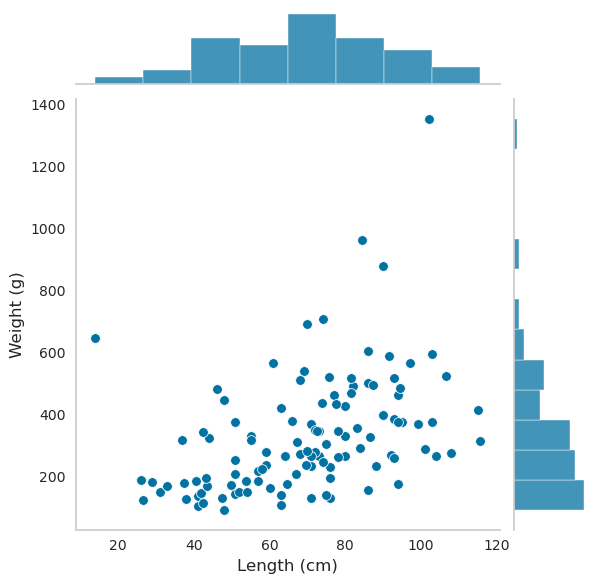

In [7]:
sns.jointplot(x='length', y= 'weight', data= biomass_data_1)  #, kind='hex', color='#433e85')
plt.xlabel('Length (cm)')
plt.ylabel('Weight (g)')

#### Removing Outliers

<Axes: >

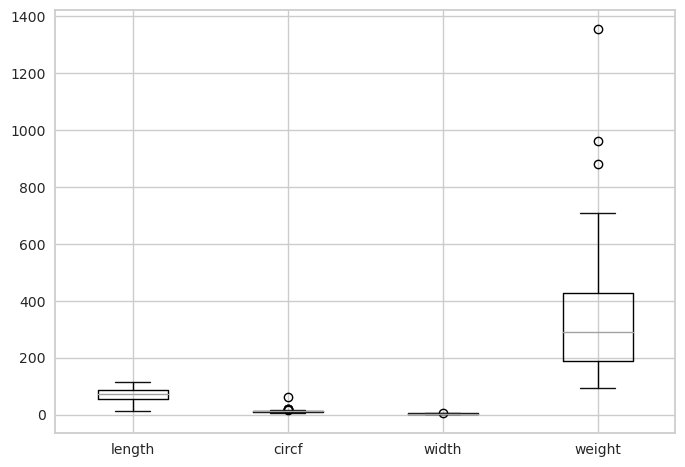

In [8]:
biomass_data_1.boxplot(['length', 'circf', 'width', 'weight'])

From the boxplot we see certain outliers in the plot and to remove these outliers we perform the following operations.

In [9]:
def remove_outliers(data, feature):
    for x in [feature]:
        q75,q25 = np.percentile(data.loc[:,x],[75,25])
        intr_qr = q75-q25

        maxx = q75+(1.5*intr_qr)
        minn = q25-(1.5*intr_qr)

        data.loc[data[x] < minn,x] = np.nan
        data.loc[data[x] > maxx,x] = np.nan

In [10]:
biomass_data_2 = biomass_data_1.copy()  # Make an hard copy

remove_outliers(biomass_data_2, 'weight')
biomass_data_2.isnull().sum()

length    0
circf     0
width     0
weight    3
dtype: int64

In [11]:
biomass_data_2 = biomass_data_2.dropna(axis = 0)
biomass_data_2.shape

(110, 4)

<Axes: >

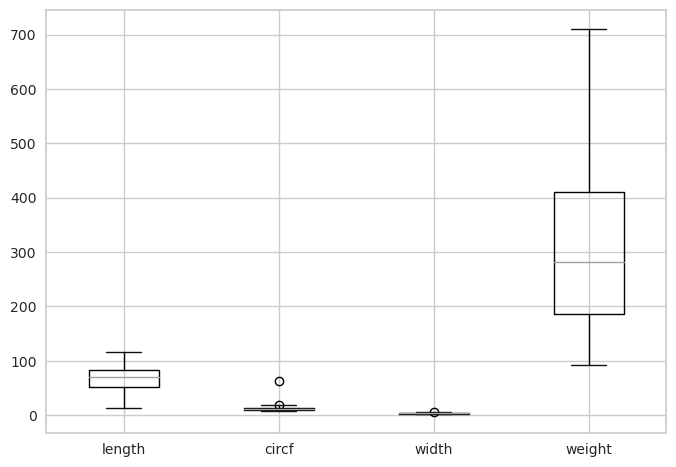

In [12]:
biomass_data_2.boxplot(['length', 'circf', 'width', 'weight'])

In [13]:
biomass_data_3 = biomass_data_2.copy()  # Make an hard copy

remove_outliers(biomass_data_3, 'circf')
biomass_data_3.isnull().sum()
biomass_data_3 = biomass_data_3.dropna(axis = 0)

<Axes: >

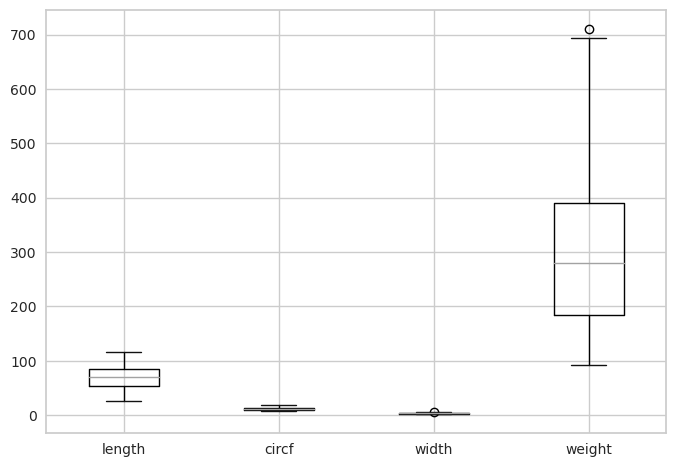

In [14]:
biomass_data_3.boxplot(['length', 'circf', 'width', 'weight'])

At this point there are only two more outliers in the data and we remove them performing the previous operation again.

In [15]:
biomass_data_4 = biomass_data_3.copy()  # Make an hard copy

remove_outliers(biomass_data_4, 'width')
remove_outliers(biomass_data_4, 'weight')
biomass_data_4.isnull().sum()

length    0
circf     0
width     1
weight    1
dtype: int64

In [16]:
biomass_data_4 = biomass_data_4.dropna(axis = 0)

#### Visualizing the new_dataset 

<Axes: >

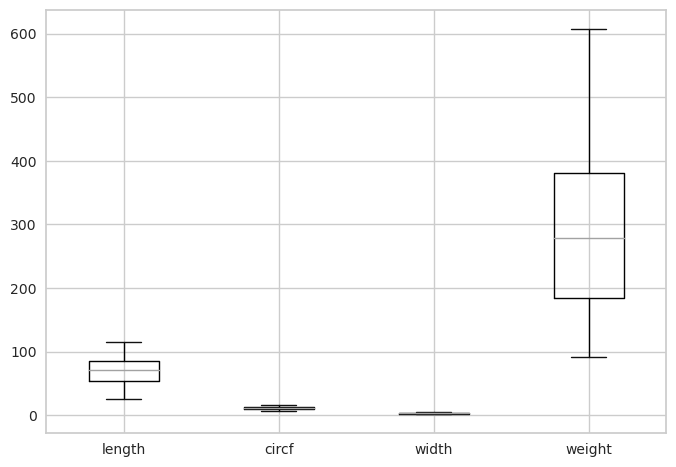

In [17]:
biomass_data_4.boxplot(['length', 'circf', 'width', 'weight'])

At this point, there are no more outliers and we can now visualize the features.

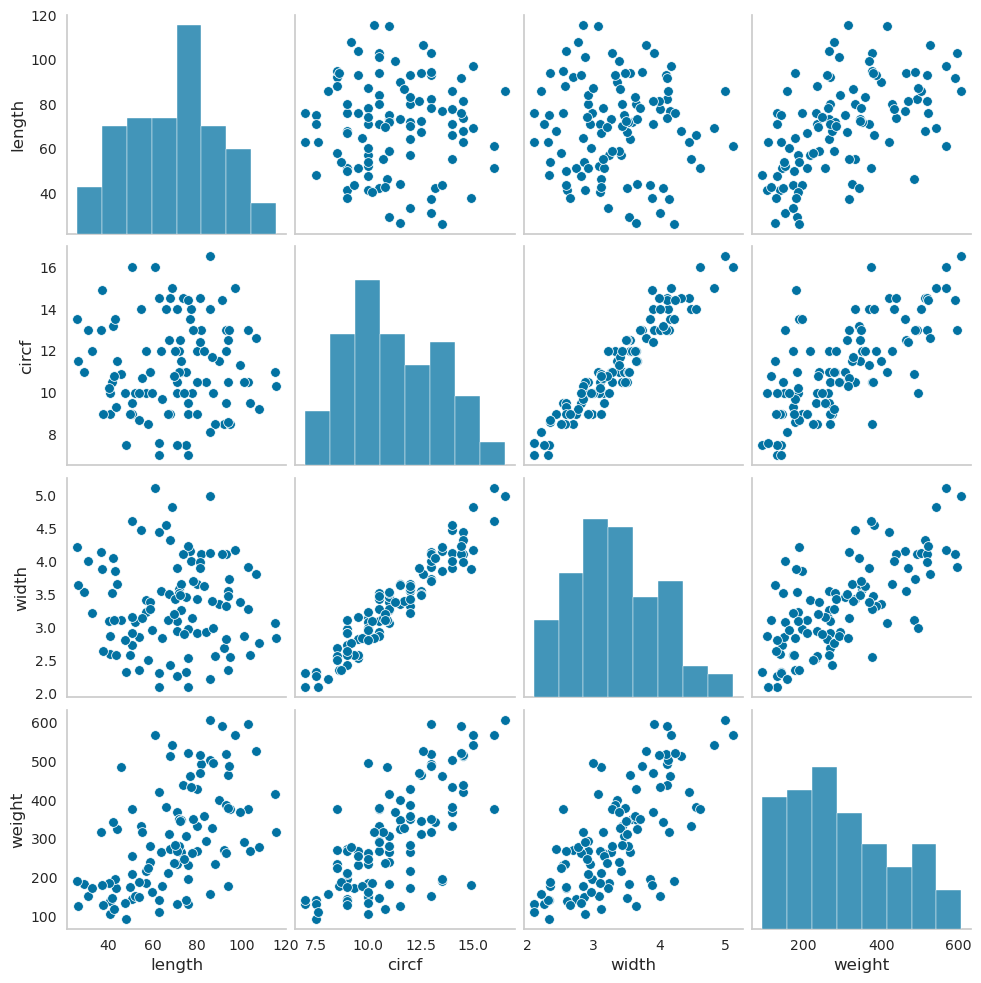

In [18]:
sns.pairplot(biomass_data_4)

#### Using the new data for the rest of the analysis

In [19]:
data = biomass_data_4.copy()

#### Visualizing the Interaction of the predictors with the response (WEIGHT)

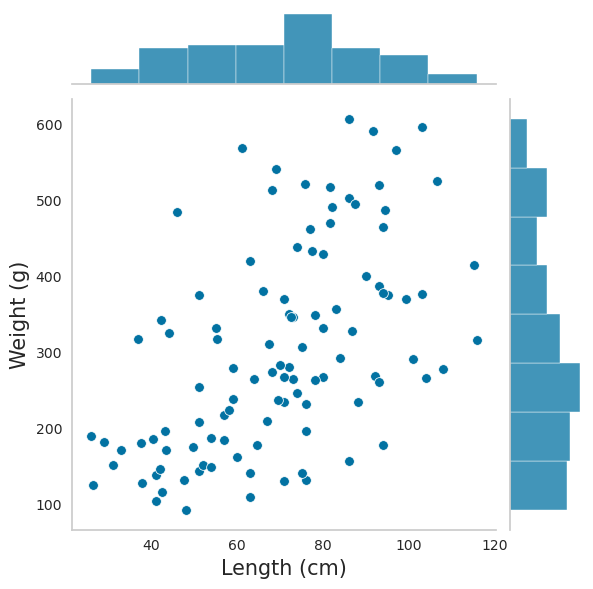

In [20]:
ax = sns.jointplot(x='length', y= 'weight', data= data)  #, kind='hex', color='#433e85')
ax.set_axis_labels(xlabel='Length (cm)', ylabel='Weight (g)', size=15)
#ax.set(xlabel='common xlabel', ylabel='common ylabel')
plt.show()

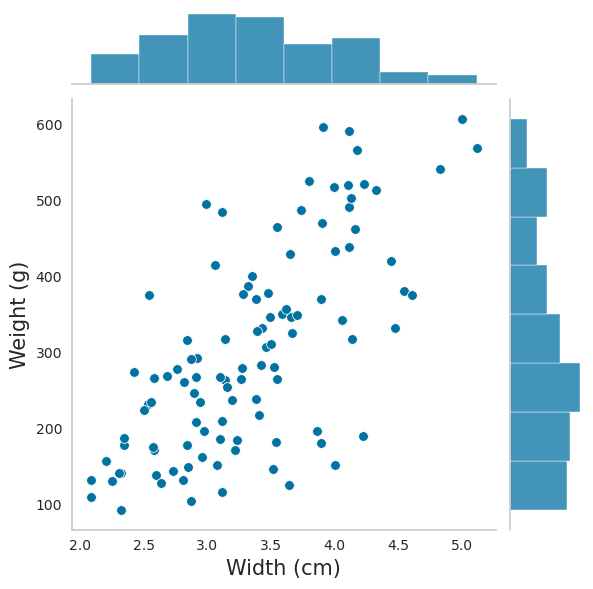

In [21]:
ax = sns.jointplot(x='width', y= 'weight', data= data)  #, kind='hex', color='#433e85')
ax.set_axis_labels(xlabel='Width (cm)', ylabel='Weight (g)', size=15)
#ax.set(xlabel='common xlabel', ylabel='common ylabel')
plt.show()

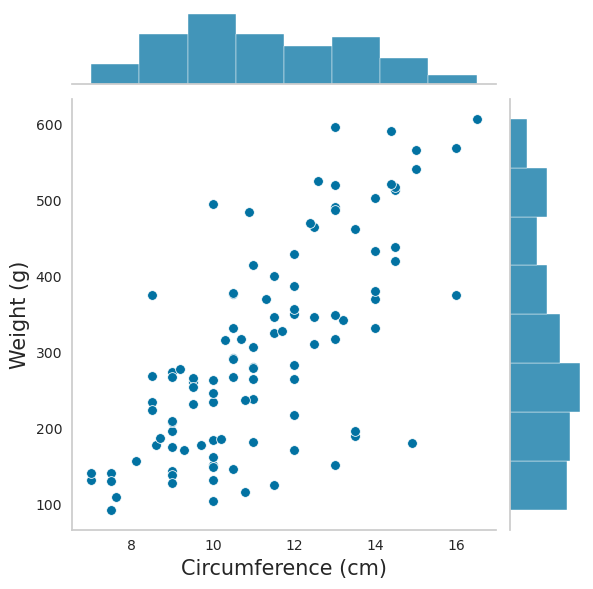

In [22]:
ax = sns.jointplot(x='circf', y= 'weight', data= data)  #, kind='hex', color='#433e85')
ax.set_axis_labels(xlabel='Circumference (cm)', ylabel='Weight (g)', size=15)
#ax.set(xlabel='common xlabel', ylabel='common ylabel')
plt.show()

### Relationship between the width and the circumference

In [23]:
data['circf'] / data['width']

0      3.521127
1      3.301981
2      3.523194
3      3.129278
4      3.746057
         ...   
106    3.379520
107    3.558719
108    3.155873
109    3.415560
110    3.832305
Length: 106, dtype: float64

In [24]:
np.mean(data['circf'] / data['width'])

3.364672805651713

The average value of the ratio between the cirumference and the width which is equivalent to $\pi$. But, the value from above is slightly more than $3.142$ which is partly because the width of the biomass is a bit more skewed.

#### Correlation between the Features

<Axes: >

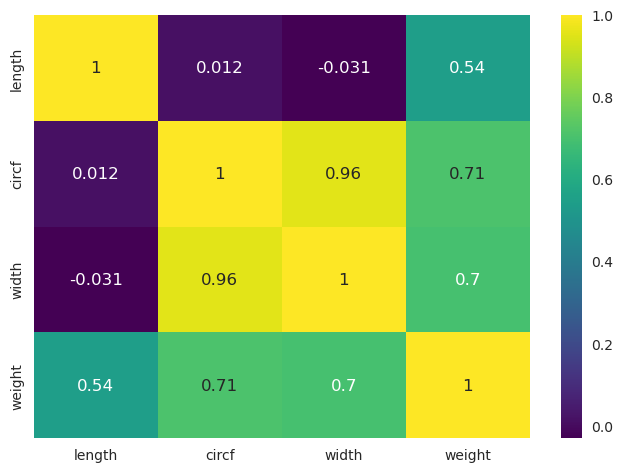

In [25]:
sns.heatmap(data.corr(), annot=True, cmap="viridis")

Write about this in the results ...

### Weight Model

In [26]:
class WeightModel:
    """
    WeightModel is a regression machine learning solver.
    
    The use of multiple regression algorithms is used to efficiently predict
    the weight.
    
    """
    def __init__(self, feature, label, test_fraction = 0.2):
        """
        Constructor method for the WeightModel class.

        Parameters:
        feature: pandas dataframe
            N x k dimension matrix containing the input features, where N is the number of 
            observations and k is the number of features
        label: pandas dataframe
            N x 1 dimension matrix containing the corresponding labels for each input observation
        test_fraction: float
            The fraction of the data to be used as test data. The default value is 0.2 (i.e., 20% 
            of the data is used for testing).
        """
        self.data = feature.to_numpy()  # converts the dataframe to numpy array
        self.label = label.to_numpy().reshape(-1, )
        self.test_fraction = test_fraction
        self.transform_scaler = 0  # scales a new dataset before predicting
        self.transform_label = 0
        
    def dataset_scaler(self, rand_num=42):
        """
        This method performs feature scaling on the input data.

        Returns:
        Tuple:
            X_train_scaled: numpy array
                Scaled training input feature data
            X_test_scaled: numpy array
                Scaled testing input feature data
            y_train: numpy array
                Training labels
            y_test: numpy array
                Testing labels
        """
        start_state = rand_num  # random seed for solution replication
        X_train, X_test, y_train, y_test = train_test_split(self.data, self.label, 
                                                            test_size=self.test_fraction, random_state=start_state)
        
        self.transform_scaler = StandardScaler()  # scikit learn library for scaling
        self.transform_scaler.fit(self.data)
        
        X_trained_scaled, X_test_scaled = self.transform_scaler.transform(X_train), self.transform_scaler.transform(X_test)
        
        # transform label
        self.transform_label = StandardScaler()
        self.transform_label.fit(self.label.reshape(-1, 1))
        
        y_trained_scaled, y_test_scaled = self.transform_label.transform(y_train.reshape(-1, 1)), \
                                    self.transform_label.transform(y_test.reshape(-1, 1))
        
        return X_trained_scaled, X_test_scaled, y_trained_scaled, y_test_scaled
    
    def ml_regressors(self, regressor = 'SVR', default=True):
        """
        This method trains a regression model on the input data.

        Parameters:
        Regressors: str, default 'SVR'
            A string specifying the type of regressors to use. There are four regressors that are used.
            
        Returns:
        Trained regression model object.
        """
        # using default regressors
        if default:
            regressor_dict = {
                   'SVR': SVR(),
                   'RF': RandomForestRegressor(),
                   'MLP': MLPRegressor(),
                   'LR': LinearRegression()
                              }
            
        else:
            regressor_dict = {
                   'SVR': SVR(kernel=kern, C=c_val, gamma=gam_val, epsilon=eps_val),
                   'RF': RandomForestRegressor(n_estimators=n_est, 
                             max_features=max_featR),
                   'MLP': MLPRegressor(
                            hidden_layer_sizes=hid_lay,
                            learning_rate_init=tol,
                            early_stopping=True,
                            random_state=0,
                            max_iter=max_i
                        ),
                   'LR': LinearRegression()
                              }
        
            
        selected_regressor = regressor_dict[regressor]
        Xtrain_scale, _, ytrain_scale, _ = self.dataset_scaler()

        my_model = selected_regressor.fit(Xtrain_scale, ytrain_scale)  
        
        return my_model
        
    def weight_predict(self, model, X_test):
        """Predict the weight given the test dataset."""
        
        unscaled = model.predict(X_test)
        scaled = self.transform_label.inverse_transform(unscaled.reshape(-1, 1))
        
        return scaled
        
        
    def model_score(self, model, X_test, y_test):
        """
        This method calculates the accuracy score of the trained model on the test data.

        Parameters:
        model: sklearn model object
            The trained model object
        X_test: numpy array
            The testing feature data
        y_test: numpy array
            The testing labels

        Returns:
        float:
            The accuracy score of the model on the testing data.
        """
        
        return model.score(X_test, y_test)
        

    

In [27]:
def MAE(arr):
    return np.mean(np.abs(arr[:, 0] - arr[:, 1]))

def error_perc(arr):
    return np.mean(np.abs((arr[:, 1] - arr[:, 0]) / arr[:, 1]) *100)

### Initializing the Model

In [28]:
independent_var = data[['length', 'circf', 'width']]
response_var = data['weight']

weight_model = WeightModel(feature = independent_var, 
                        label = response_var, 
                        test_fraction = 0.2)

Extracting the **y_Scaled** Value to be used to test the score of the models.

In [29]:
X_train_sca, X_test_scaled, y_train_sca, y_test = weight_model.dataset_scaler(rand_num=30)

In [30]:
y_actual = weight_model.transform_label.inverse_transform(y_test.reshape(-1, 1))
y_actual

array([[607.2],
       [465. ],
       [486.4],
       [369.6],
       [520.6],
       [306.8],
       [151. ],
       [513.6],
       [324.8],
       [420.2],
       [189. ],
       [469.8],
       [157. ],
       [187. ],
       [331.8],
       [310.6],
       [519.4],
       [375.8],
       [246.6],
       [495. ],
       [317.4],
       [377.8]])

### SVR

In [31]:
trained_model = weight_model.ml_regressors(regressor='SVR')

In [32]:
y_pred = weight_model.weight_predict(trained_model, X_test_scaled)
err_svr = np.hstack((y_pred, y_actual))
err_svr

array([[588.29957949, 607.2       ],
       [428.87053158, 465.        ],
       [472.92577465, 486.4       ],
       [391.98776161, 369.6       ],
       [488.0710429 , 520.6       ],
       [308.38614908, 306.8       ],
       [188.1897174 , 151.        ],
       [446.10268532, 513.6       ],
       [200.17500982, 324.8       ],
       [423.62627402, 420.2       ],
       [202.44468426, 189.        ],
       [432.32109177, 469.8       ],
       [173.67322447, 157.        ],
       [136.75469894, 187.        ],
       [356.47022353, 331.8       ],
       [296.3727439 , 310.6       ],
       [519.3461844 , 519.4       ],
       [243.61660705, 375.8       ],
       [231.62832788, 246.6       ],
       [287.99405421, 495.        ],
       [216.06029822, 317.4       ],
       [368.89343886, 377.8       ]])

In [33]:
print('The Mean Absolute Error for the SVR is:', MAE(err_svr))
print(f'The Percentage Error for the SVR is: {np.round(error_perc(err_svr), 2)} %')

The Mean Absolute Error for the SVR is: 44.49754388055342
The Percentage Error for the SVR is: 12.97 %


#### It takes a while to run the grid search so, this cell was not reran.

In [41]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'C': [0.01,0.1, 1, 10, 100, 1000, 5000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'rbf','poly'],
              'epsilon':[0.0001,0.002, 0.5, 1, 0.3, 2]}

'''param_grid = {'kernel': ('linear', 'rbf','poly'), 
              'C':[1.5, 10],'gamma': [1e-7, 1e-4],
              'epsilon':[0.1,0.2,0.5,0.3]}'''

grid = GridSearchCV(SVR(), param_grid)  #, refit = True, verbose = 3) print out the progress report

# fitting the model for grid search
grid.fit(X_train_sca, y_train_sca)
grid.best_params_

{'C': 100, 'epsilon': 0.3, 'gamma': 0.01, 'kernel': 'rbf'}

Grid Search for `Random Forest`

In [47]:
# defining parameter range
param_grid_rf = {'n_estimators': [0.2, 0.4, 1, 2, 3, 4, 5, 6],
              'max_features': [1, 2, 3, 4]}
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf)  #, refit = True, verbose = 3) print out the progress report

# fitting the model for grid search
grid_rf.fit(X_train_sca, y_train_sca)
print('The best parameter for RF is', grid_rf.best_params_)

The best parameter for RF is {'max_features': 2, 'n_estimators': 6}


Grid Search `Neural Network- mlp`

In [48]:
param_grid_mlp = {'hidden_layer_sizes': [500, 2000, 3000, 1400, 5, 60, 1000],
              'learning_rate_init': [1, 0.1, 0.001, 0.0001, 0.0005, 0.00001, 1e-8],
              'max_iter': [1, 10, 20, 30, 40, 100, 200, 1000]
                 
                 }
grid_mlp = GridSearchCV(MLPRegressor(), param_grid_mlp)  #, refit = True, verbose = 3) print out the progress report

# fitting the model for grid search
grid_mlp.fit(X_train_sca, y_train_sca)
print('The best parameter for SVR is', grid_mlp.best_params_)

The best parameter for SVR is {'hidden_layer_sizes': 2000, 'learning_rate_init': 0.001, 'max_iter': 40}


In [34]:
def robust_model(data, rand=30, default=True):
    """Train and predict Weights using the Four Regressors Model.
    
    Param
    ------
    Data: DataFrame containing the independent and dependent variables.
    rand: Used for cross validation to randomize the training data.
    
    returns:
    DataFrames of the model training of the test dataset and the error analysis.
    """
    independent_var = data[['length', 'circf', 'width']]
    response_var = data['weight']

    model = WeightModel(feature = independent_var, 
                            label = response_var, 
                            test_fraction = 0.2)
    
    # Splitting the dataset
    X_train_sca, X_test_scaled, y_train_sca, y_test = model.dataset_scaler(rand_num=rand)
    # Transform the y_test dataset to be used for validation
    y_actual = model.transform_label.inverse_transform(y_test.reshape(-1, 1))
    
    # Training the model using the four regressor algorithms
    svr_model = model.ml_regressors(regressor='SVR', default=default)
    rf_model = model.ml_regressors(regressor='RF', default=default)
    mlp_model = model.ml_regressors(regressor='MLP', default=default)
    lr_model = model.ml_regressors(regressor='LR', default=default)
    
    # Check RESIDUAL to see how the model behaves with the training dataset
    y_train_calc_svr = model.weight_predict(svr_model, X_train_sca)
    y_train_calc_rf = model.weight_predict(rf_model, X_train_sca)
    y_train_calc_mlp = model.weight_predict(mlp_model, X_train_sca)
    y_train_calc_lr = model.weight_predict(lr_model, X_train_sca)
    # obtaining the actual training y_val
    ytrain = model.transform_label.inverse_transform(y_train_sca.reshape(-1, 1))
    
    train_pred_stacked = np.hstack((ytrain, y_train_calc_svr, y_train_calc_rf, y_train_calc_mlp, y_train_calc_lr))
    residual_df = pd.DataFrame(train_pred_stacked, columns=['y_train', 'SVR_pred', 'RF_pred', 'MLP_pred', 'LR_pred'])
    
    # Predicting the test variables
    y_pred_svr = model.weight_predict(svr_model, X_test_scaled)
    y_pred_rf = model.weight_predict(rf_model, X_test_scaled)
    y_pred_mlp = model.weight_predict(mlp_model, X_test_scaled)
    y_pred_lr = model.weight_predict(lr_model, X_test_scaled)
    
    # Combining the prediction and creating a dataframe of all the regressor algorithms.
    err_stack = np.hstack((y_actual, y_pred_svr, y_pred_rf, y_pred_mlp, y_pred_lr))
    prediction_df = pd.DataFrame(err_stack, columns=['y_test', 'SVR_pred', 'RF_pred', 'MLP_pred', 'LR_pred'])
    
    # Combining the error and creating a dataframe
    MAE_stack = np.vstack((
        MAE(np.hstack((y_actual, y_pred_svr))),
        MAE(np.hstack((y_actual, y_pred_rf))),
        MAE(np.hstack((y_actual, y_pred_mlp))),
        MAE(np.hstack((y_actual, y_pred_lr))),
    ))
    
    MAE_df = pd.DataFrame(MAE_stack.T, columns=['SVR MAE', 'RF MAE', 'MLP MAE', 'LR MAE'])
    
    return prediction_df, MAE_df, residual_df

In [35]:
def error_perc_pandas(pandas_arr, reg):
    return np.mean(np.abs((pandas_arr['y_test'] - pandas_arr[f'{reg}_pred']) / pandas_arr['y_test']) *100)

### Plotting the Predicted Results

In [36]:
def plot_predicted(pred_data):
    plt.figure(figsize=(10, 8))
    plt.plot(pred_data['y_test'], 'r.', markersize=12, label='Test Data')
    plt.plot(pred_data['y_test'], label='Test Data')
    plt.plot(pred_data['SVR_pred'], label='SVR Prediction')
    plt.plot(pred_data['RF_pred'], label='RF Prediction')
    plt.plot(pred_data['MLP_pred'], label='MLP Prediction')
    plt.plot(pred_data['LR_pred'], label='LR Prediction')
    plt.legend()
    plt.ylabel('Weight (g)', fontsize=18)
    plt.xlabel('Test Data', fontsize=18)
    plt.xticks(size=18)
    plt.yticks(size=18)

### K-Fold Cross Validation

#### Rand = 2

In [37]:
pred_df2, mae_df2, res_df2 = robust_model(data, rand=2)
pred_df2

,y_test,SVR_pred,RF_pred,MLP_pred,LR_pred
0,187.0,136.754699,162.538,139.900752,105.904704
1,486.4,472.925775,471.652,469.770840,448.637321
2,332.0,318.609019,317.212,323.363798,337.408802
3,184.8,201.047500,195.722,225.675701,229.372022
4,267.4,250.023140,263.636,240.651178,264.531881
5,420.2,423.626274,428.088,434.492028,432.176330
6,216.8,230.255895,236.560,265.398951,269.956165
7,346.6,333.110676,335.640,345.287262,349.134100
8,92.0,140.626937,110.898,118.630245,70.278545
9,195.6,243.107448,219.460,233.203720,257.012730


In [38]:
mae_df2

,SVR MAE,RF MAE,MLP MAE,LR MAE
0,32.791561,26.256727,35.962861,44.465942


In [39]:
print('The Percentage Error for the SVR is:', np.round(error_perc_pandas(pred_df2[['y_test', 'SVR_pred']], reg='SVR'), 2),'%')
print('The Percentage Error for the RF is:', np.round(error_perc_pandas(pred_df2[['y_test', 'RF_pred']], reg='RF'), 2),'%')
print('The Percentage Error for the MLP is:', np.round(error_perc_pandas(pred_df2[['y_test', 'MLP_pred']], reg='MLP'), 2),'%')
print('The Percentage Error for the LR is:', np.round(error_perc_pandas(pred_df2[['y_test', 'LR_pred']], reg='LR'), 2),'%')

The Percentage Error for the SVR is: 12.85 %
The Percentage Error for the RF is: 9.09 %
The Percentage Error for the MLP is: 13.87 %
The Percentage Error for the LR is: 17.56 %


In [40]:
def plot_predicted(pred_data):
    kk = plt.figure(figsize=(10, 8))
    plt.plot(pred_data['y_test'], 'r.', markersize=12, label='Test Data')
    plt.plot(pred_data['y_test'], label='Test Data')
    plt.plot(pred_data['SVR_pred'], label='SVR Prediction')
    plt.plot(pred_data['RF_pred'], label='RF Prediction')
    plt.plot(pred_data['MLP_pred'], label='MLP Prediction')
    plt.plot(pred_data['LR_pred'], label='LR Prediction')
    plt.ylabel('Weight (g)', fontsize=18)
    plt.xlabel('Test Data', fontsize=18)
    plt.xticks(size=18)
    plt.yticks(size=18)
    plt.legend()

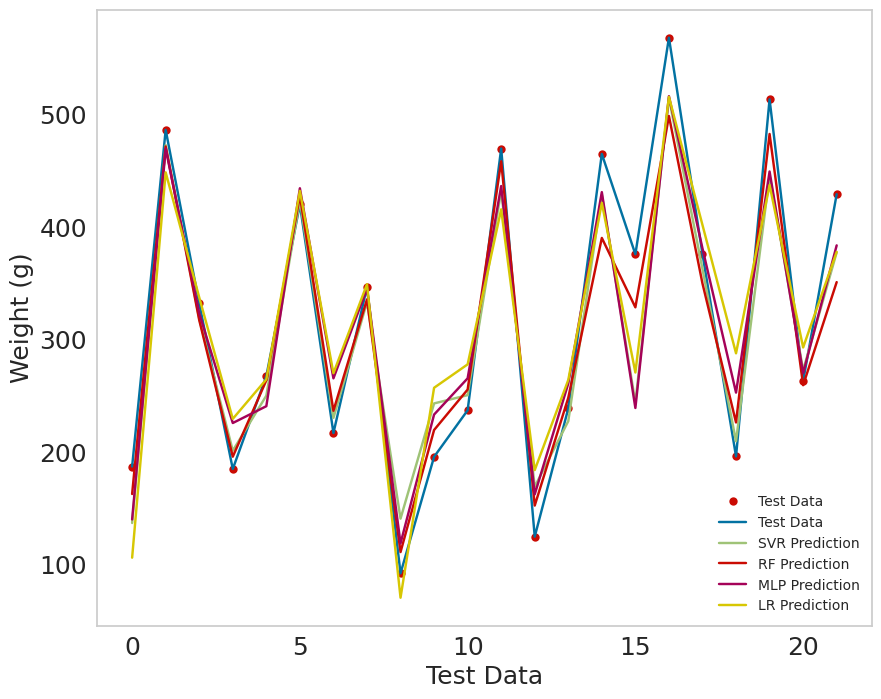

In [42]:
plot_predicted(pred_df2)

##### Rand = 5

In [43]:
pred_df5, mae_df5, res_df5 = robust_model(data, rand=5)
pred_df5

,y_test,SVR_pred,RF_pred,MLP_pred,LR_pred
0,196.0,209.457298,224.962,259.105185,287.684507
1,273.2,158.623386,179.934,181.176091,167.838689
2,306.8,308.386149,306.054,318.232394,328.805446
3,263.0,272.505210,261.350,274.913748,292.863759
4,375.0,388.489083,366.268,411.006746,424.612039
5,246.6,231.628328,236.178,244.278474,252.395390
6,267.6,243.947013,294.720,258.882720,269.202362
7,130.0,138.795686,135.014,145.944491,143.819150
8,346.6,333.110676,339.978,342.797478,349.134100
9,519.4,519.346184,512.972,506.282084,484.763949


In [44]:
mae_df5

,SVR MAE,RF MAE,MLP MAE,LR MAE
0,25.527151,17.017727,30.413779,39.052034


In [45]:
print('The Percentage Error for the SVR is:', np.round(error_perc_pandas(pred_df5[['y_test', 'SVR_pred']], reg='SVR'), 2),'%')
print('The Percentage Error for the RF is:', np.round(error_perc_pandas(pred_df5[['y_test', 'RF_pred']], reg='RF'), 2),'%')
print('The Percentage Error for the MLP is:', np.round(error_perc_pandas(pred_df5[['y_test', 'MLP_pred']], reg='MLP'), 2),'%')
print('The Percentage Error for the LR is:', np.round(error_perc_pandas(pred_df5[['y_test', 'LR_pred']], reg='LR'), 2),'%')

The Percentage Error for the SVR is: 9.17 %
The Percentage Error for the RF is: 6.55 %
The Percentage Error for the MLP is: 11.46 %
The Percentage Error for the LR is: 15.55 %


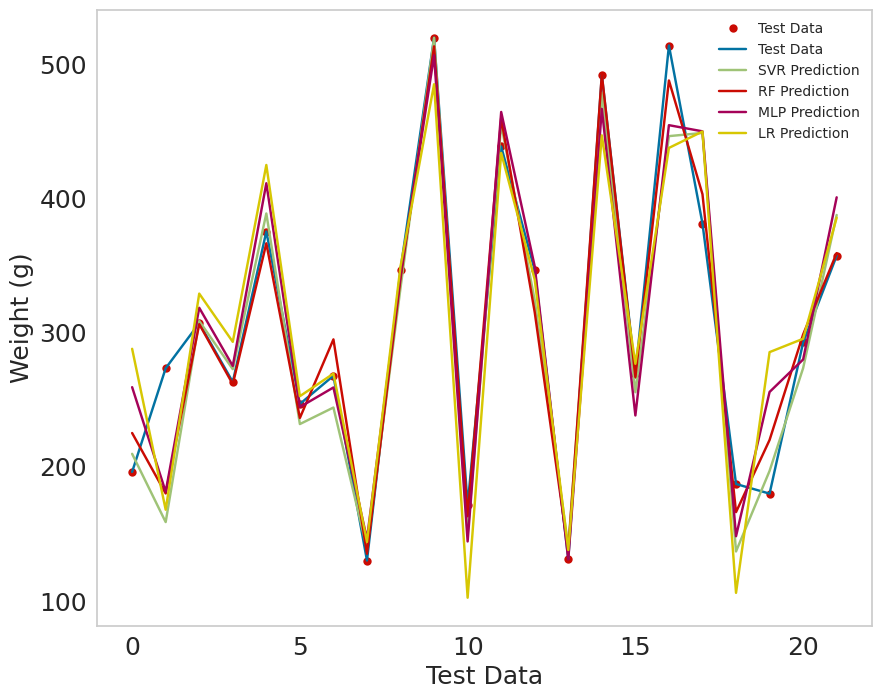

In [46]:
plot_predicted(pred_df5)

##### Rand = 20

In [47]:
pred_df20, mae_df, res_df20 = robust_model(data, rand=20)
pred_df20

,y_test,SVR_pred,RF_pred,MLP_pred,LR_pred
0,140.4,153.831617,139.448,157.110690,165.697926
1,265.2,278.706054,274.076,308.555171,310.525979
2,290.4,311.315473,318.780,315.998931,349.361729
3,279.8,302.815673,287.070,318.289704,325.587182
4,254.0,179.933704,230.030,196.387520,194.450326
5,130.0,138.795686,132.226,144.802333,143.819150
6,484.4,168.831548,378.042,197.563633,187.228926
7,216.8,230.255895,240.822,261.227363,269.956165
8,162.2,188.345281,173.146,207.907511,209.882041
9,607.2,588.299579,581.354,625.827694,596.170163


In [48]:
mae_df

,SVR MAE,RF MAE,MLP MAE,LR MAE
0,38.25564,23.138364,43.95914,54.617363


In [49]:
print('The Percentage Error for the SVR is:', np.round(error_perc_pandas(pred_df20[['y_test', 'SVR_pred']], reg='SVR'), 2),'%')
print('The Perpred_df20centage Error for the RF is:', np.round(error_perc_pandas(pred_df20[['y_test', 'RF_pred']], reg='RF'), 2),'%')
print('The Percentage Error for the MLP is:', np.round(error_perc_pandas(pred_df20[['y_test', 'MLP_pred']], reg='MLP'), 2),'%')
print('The Percentage Error for the LR is:', np.round(error_perc_pandas(pred_df20[['y_test', 'LR_pred']], reg='LR'), 2),'%')

The Percentage Error for the SVR is: 11.96 %
The Perpred_df20centage Error for the RF is: 7.5 %
The Percentage Error for the MLP is: 14.89 %
The Percentage Error for the LR is: 19.37 %


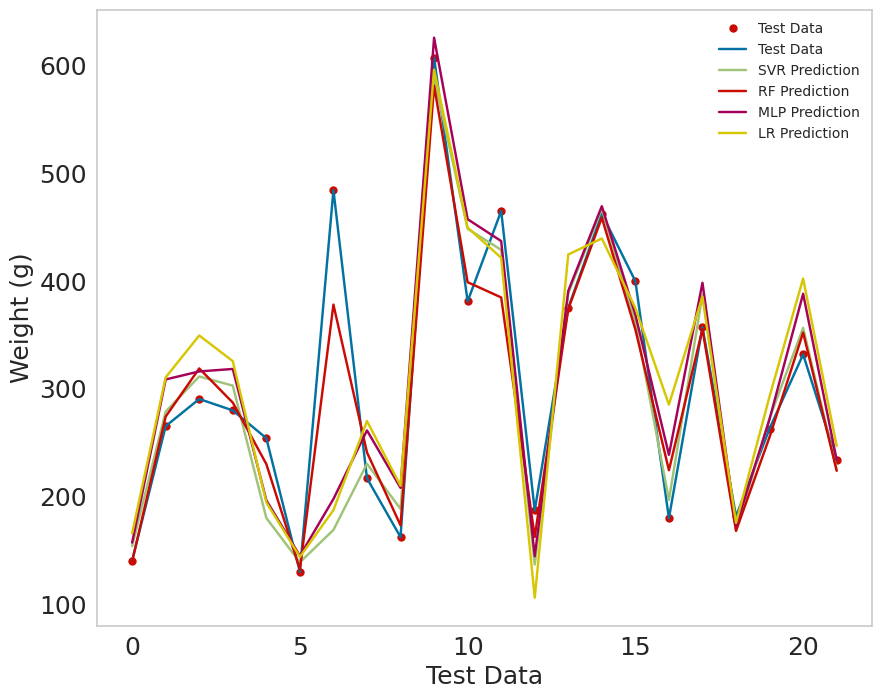

In [50]:
plot_predicted(pred_df20)

#### Rand = 100

In [51]:
pred_df100, mae_df100, res_df100 = robust_model(data, rand=100)
pred_df100

,y_test,SVR_pred,RF_pred,MLP_pred,LR_pred
0,149.2,166.632426,148.256,191.036996,176.173358
1,92.0,140.626937,117.736,113.838173,70.278545
2,151.8,175.140329,169.794,197.880144,194.732425
3,346.6,333.110676,344.816,349.043796,349.134100
4,387.2,376.424818,373.024,389.528683,387.386293
5,223.4,144.601772,193.888,159.697219,136.306705
6,177.8,191.175222,172.156,212.303883,209.350928
7,209.2,226.531288,210.012,223.240007,241.235619
8,350.4,326.009610,333.584,344.137749,342.372834
9,246.6,231.628328,233.718,247.423717,252.395390


In [52]:
mae_df100

,SVR MAE,RF MAE,MLP MAE,LR MAE
0,34.291846,23.315545,35.271932,40.735532


In [53]:
print('The Percentage Error for the SVR is:', np.round(error_perc_pandas(pred_df100[['y_test', 'SVR_pred']], reg='SVR'), 2),'%')
print('The Percentage Error for the RF is:', np.round(error_perc_pandas(pred_df100[['y_test', 'RF_pred']], reg='RF'), 2),'%')
print('The Percentage Error for the MLP is:', np.round(error_perc_pandas(pred_df100[['y_test', 'MLP_pred']], reg='MLP'), 2),'%')
print('The Percentage Error for the LR is:', np.round(error_perc_pandas(pred_df100[['y_test', 'LR_pred']], reg='LR'), 2),'%')

The Percentage Error for the SVR is: 14.73 %
The Percentage Error for the RF is: 12.08 %
The Percentage Error for the MLP is: 15.79 %
The Percentage Error for the LR is: 16.9 %


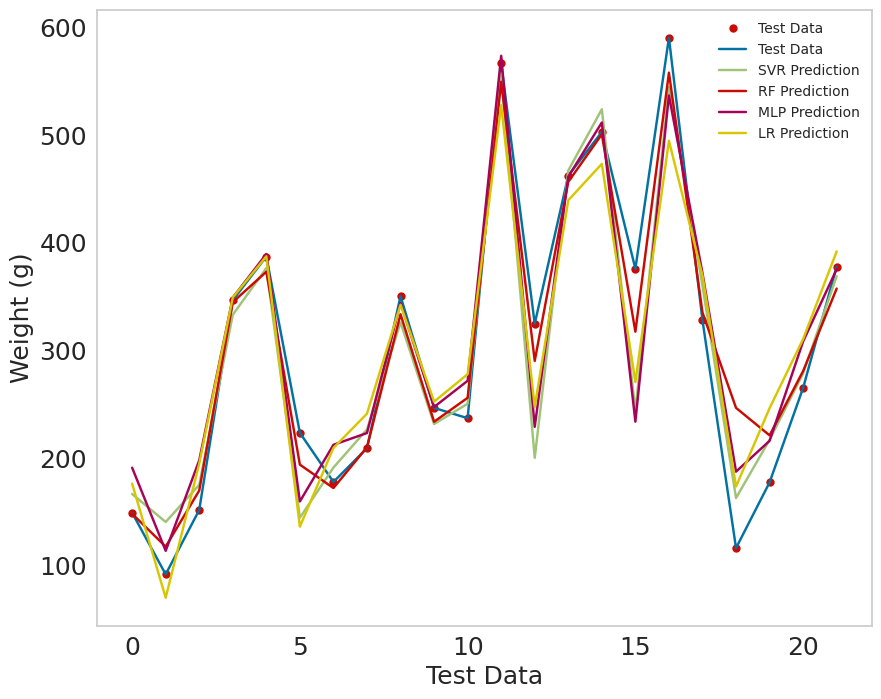

In [54]:
plot_predicted(pred_df100)

#### Rand = 300

In [55]:
pred_df300, mae_df300, res_df300 = robust_model(data, rand=300)
pred_df300

,y_test,SVR_pred,RF_pred,MLP_pred,LR_pred
0,128.2,155.637398,134.220,122.286635,85.193947
1,415.0,358.057043,379.610,378.354646,425.035474
2,177.8,191.175222,172.410,213.458517,209.350928
3,381.0,448.453711,402.236,457.389679,449.543039
4,184.8,201.047500,194.374,232.498209,229.372022
5,346.2,323.835230,331.170,349.543057,339.224367
6,429.2,377.457687,352.622,388.316495,377.893081
7,349.0,396.464535,416.378,410.369493,388.005759
8,187.0,136.754699,169.260,140.035503,105.904704
9,146.0,184.727687,193.404,213.476275,213.269254


In [56]:
mae_df300

,SVR MAE,RF MAE,MLP MAE,LR MAE
0,28.245253,19.036364,29.772422,36.309663


In [57]:
print('The Percentage Error for the SVR is:', np.round(error_perc_pandas(pred_df300[['y_test', 'SVR_pred']], reg='SVR'), 2),'%')
print('The Percentage Error for the RF is:', np.round(error_perc_pandas(pred_df300[['y_test', 'RF_pred']], reg='RF'), 2),'%')
print('The Percentage Error for the MLP is:', np.round(error_perc_pandas(pred_df300[['y_test', 'MLP_pred']], reg='MLP'), 2),'%')
print('The Percentage Error for the LR is:', np.round(error_perc_pandas(pred_df300[['y_test', 'LR_pred']], reg='LR'), 2),'%')

The Percentage Error for the SVR is: 10.86 %
The Percentage Error for the RF is: 7.04 %
The Percentage Error for the MLP is: 12.25 %
The Percentage Error for the LR is: 15.87 %


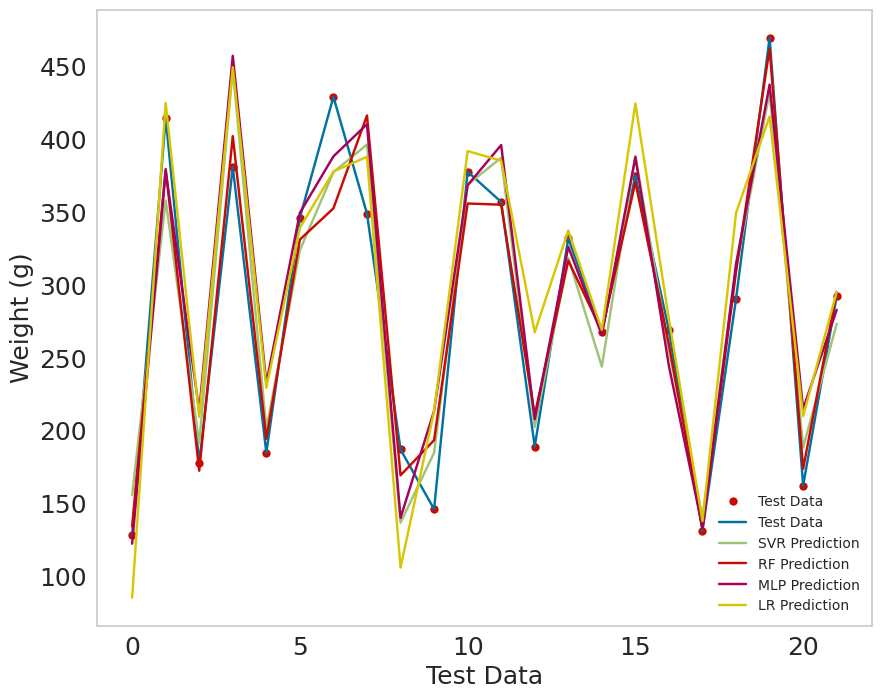

In [58]:
plot_predicted(pred_df300)